# 05 - Evaluation & Analysis



## Objective
Load the best saved model, reproduce the test split, visualize parity/residuals/overlay, and report metrics.

---

### Run order
Execute notebooks in numeric order: 01 → 02 → 03 → 04 → 05. Each notebook mounts Google Drive and reads/writes intermediate artifacts so it can run independently.

---


Drive already mounted!
Best model (from artifacts): LightGBM+Flags
Metrics: RMSE=12.5570, MAE=6.4889, R²=0.996900


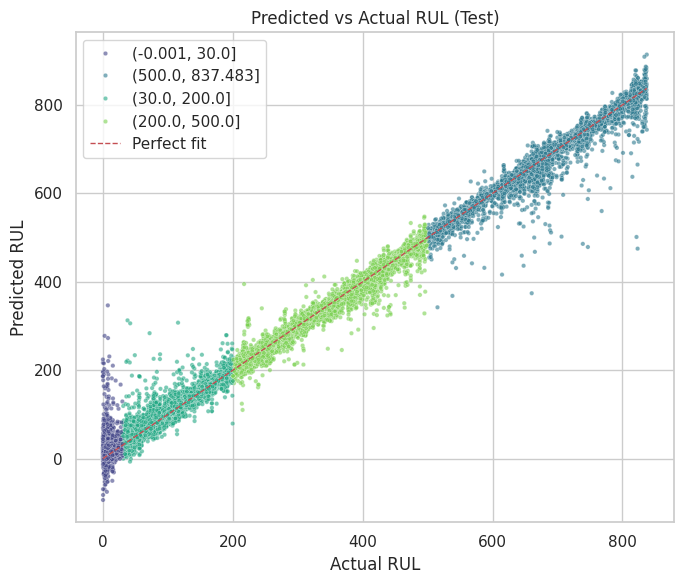

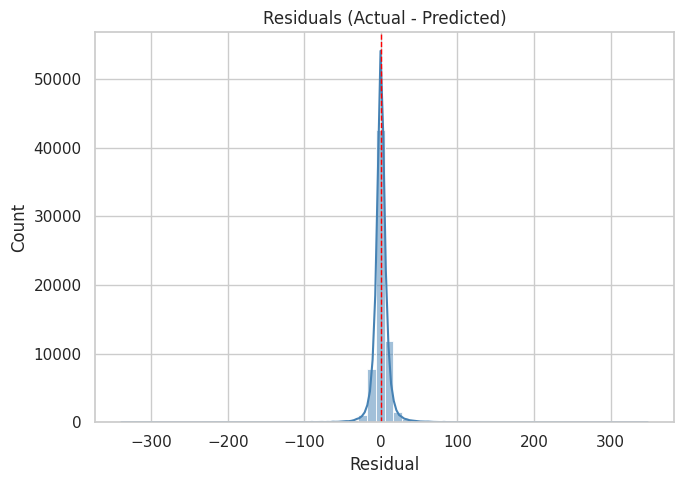

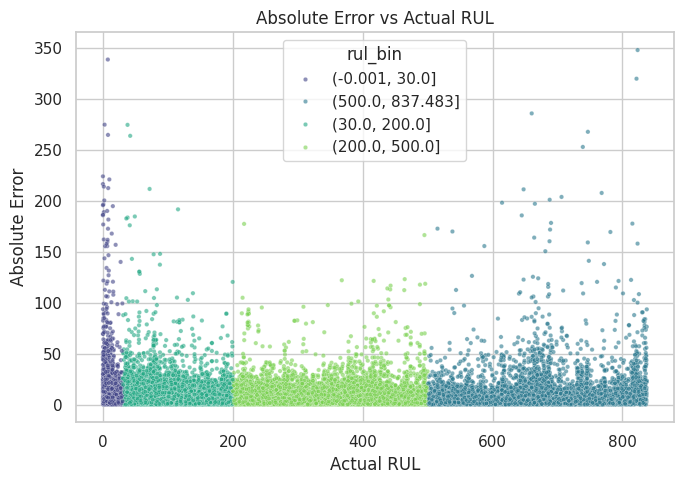

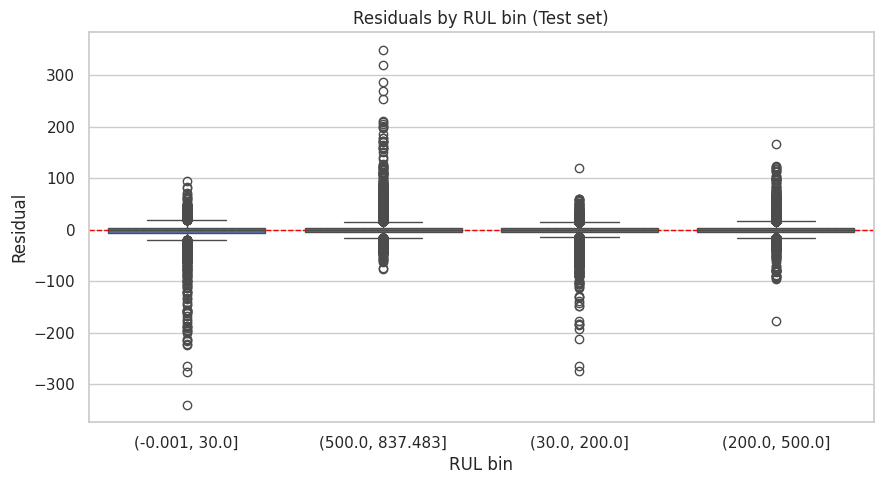

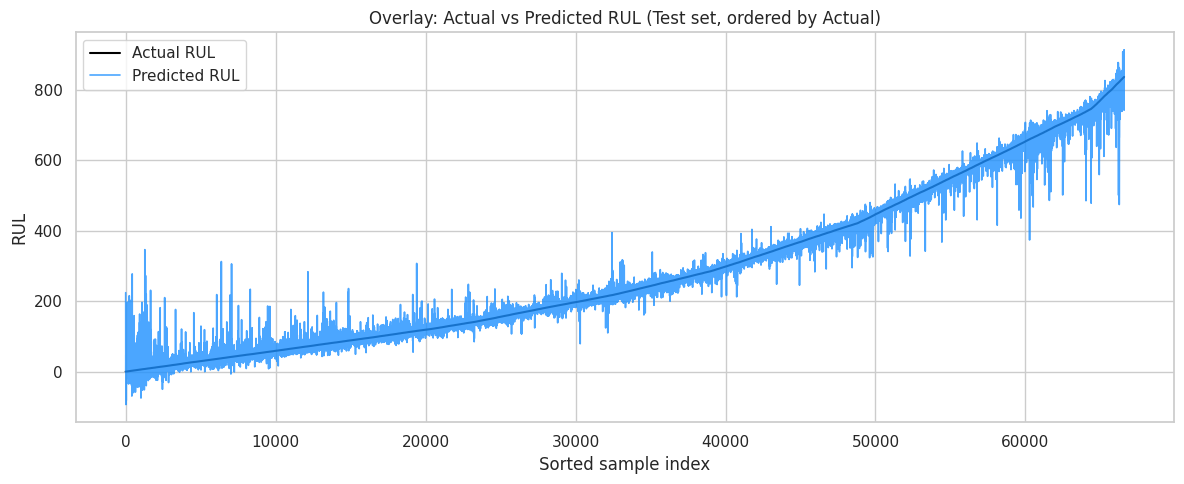

Normalized RMSE (by range): 1.4994%
MAPE (exclude zeros): 81.57%


In [2]:

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from google.colab import drive

sns.set(style='whitegrid')

# Mount
if not os.path.exists('/content/drive/MyDrive'):
    drive.mount('/content/drive')
else:
    print('Drive already mounted!')

PREP_IN = '/content/drive/MyDrive/dsp-poc/data/df_preprocessed.parquet'
ART_DIR = '/content/drive/MyDrive/dsp-poc/artifacts'

df = pd.read_parquet(PREP_IN)
exclude_cols = ['RUL', 'unit', 'cycle', 'fail_in_H']
sensor_cols = [c for c in df.columns if c not in exclude_cols]

# Recreate bins & split (same as modeling)
rul_max = float(df['RUL'].max())
bin_edges = [0, 30, 200, 500, rul_max + 1e-9]
df['rul_bin'] = pd.cut(df['RUL'], bins=bin_edges, include_lowest=True)

X = df[sensor_cols].copy()
y = df['RUL'].astype(float).copy()
bins = df['rul_bin'].astype(str)

from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.40, random_state=42)
for train_idx, test_idx in sss.split(X, bins):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    bins_train, bins_test = bins.iloc[train_idx], bins.iloc[test_idx]

# Event flags (reused)

def add_event_flags(df_in):
    df2 = df_in.copy()
    def robust_stats(s):
        q1, q3 = s.quantile(0.25), s.quantile(0.75)
        iqr = q3 - q1
        med = s.median()
        return med, q1, q3, iqr
    for s in ['sensor_04', 'sensor_05']:
        if s not in df2.columns:
            print(f'Warning: {s} not found; skipping flags.')
            continue
        med, q1, q3, iqr = robust_stats(df2[s])
        safe_iqr = iqr if iqr != 0 else 1.0
        df2[f'{s}_drop_flag']  = (df2[s] < (q1 - 1.5*safe_iqr)).astype(int)
        df2[f'{s}_spike_flag'] = (df2[s] > (q3 + 1.5*safe_iqr)).astype(int)
        df2[f'{s}_dev_med_iqr'] = (df2[s] - med) / safe_iqr
        unit_stats = df2.groupby('unit')[s].agg(['median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
        unit_stats.columns = ['u_med', 'u_q1', 'u_q3']
        df2 = df2.join(unit_stats, on='unit')
        df2[f'{s}_unit_iqr'] = (df2['u_q3'] - df2['u_q1']).replace(0, np.nan).fillna(safe_iqr)
        df2[f'{s}_dev_unit'] = (df2[s] - df2['u_med']) / df2[f'{s}_unit_iqr']
        df2.drop(columns=['u_med','u_q1','u_q3'], inplace=True)
    return df2

# Build flagged features
bins2 = df['rul_bin'].astype(str)
df_flags = add_event_flags(df)
flag_cols = [c for c in df_flags.columns if c.endswith('_drop_flag') or c.endswith('_spike_flag') or c.endswith('_dev_med_iqr') or c.endswith('_dev_unit')]
X2 = df_flags[sensor_cols + flag_cols].copy()
y2 = df_flags['RUL'].astype(float).copy()

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.40, random_state=42)
for train_idx, test_idx in sss2.split(X2, bins2):
    X2_train, X2_test = X2.iloc[train_idx], X2.iloc[test_idx]
    y2_train, y2_test = y2.iloc[train_idx], y2.iloc[test_idx]
    bins2_train, bins2_test = bins2.iloc[train_idx], bins2.iloc[test_idx]

# Determine best model from metrics_combined.csv and load
metrics_path = os.path.join(ART_DIR, 'metrics_combined.csv')
metrics_df = pd.read_csv(metrics_path)
best_row = metrics_df.sort_values(['RMSE','MAE']).iloc[0]
best_model = best_row['Model']
print('Best model (from artifacts):', best_model)

# Load accordingly
pred_func = None
if best_model == 'LightGBM+Flags':
    import joblib
    model_path = os.path.join(ART_DIR, 'best_lgbm_flags.joblib')
    model = joblib.load(model_path)
    y_pred = model.predict(X2_test)
elif best_model == 'LightGBM':
    import joblib
    model_path = os.path.join(ART_DIR, 'best_lgbm.joblib')
    model = joblib.load(model_path)
    y_pred = model.predict(X_test)
elif best_model == 'RandomForest+Flags':
    import joblib
    model_path = os.path.join(ART_DIR, 'best_rf_flags.joblib')
    model = joblib.load(model_path)
    y_pred = model.predict(X2_test)
elif best_model == 'RandomForest':
    import joblib
    model_path = os.path.join(ART_DIR, 'best_rf.joblib')
    model = joblib.load(model_path)
    y_pred = model.predict(X_test)
elif best_model == 'HistGB+Flags':
    import joblib
    model_path = os.path.join(ART_DIR, 'best_hgb_flags.joblib')
    model = joblib.load(model_path)
    y_pred = model.predict(X2_test)
elif best_model == 'HistGB':
    import joblib
    model_path = os.path.join(ART_DIR, 'best_hgb.joblib')
    model = joblib.load(model_path)
    y_pred = model.predict(X_test)
elif best_model == 'CatBoost+Flags':
    from catboost import CatBoostRegressor
    model_path = os.path.join(ART_DIR, 'best_catboost_flags.cbm')
    model = CatBoostRegressor()
    model.load_model(model_path)
    y_pred = model.predict(X2_test)
elif best_model == 'CatBoost':
    from catboost import CatBoostRegressor
    model_path = os.path.join(ART_DIR, 'best_catboost.cbm')
    model = CatBoostRegressor()
    model.load_model(model_path)
    y_pred = model.predict(X_test)
else:
    raise ValueError('Unknown best model type: ' + str(best_model))

# Select the matching test set for metrics/plots
if '+Flags' in best_model:
    y_true = y2_test.values
    bins_test_flags = bins2_test.astype(str)
else:
    y_true = y_test.values
    bins_test_flags = bins_test.astype(str)

# Metrics
rmse_val = float(np.sqrt(mean_squared_error(y_true, y_pred)))
mae_val  = float(mean_absolute_error(y_true, y_pred))
r2_val   = float(r2_score(y_true, y_pred))
print(f'Metrics: RMSE={rmse_val:.4f}, MAE={mae_val:.4f}, R²={r2_val:.6f}')

# Parity plot
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_true, y=y_pred, hue=bins_test_flags, s=10, alpha=0.6, palette='viridis')
mn, mx = y_true.min(), y_true.max()
plt.plot([mn, mx], [mn, mx], 'r--', linewidth=1, label='Perfect fit')
plt.title('Predicted vs Actual RUL (Test)')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Residuals
resid = y_true - y_pred
plt.figure(figsize=(7,5))
sns.histplot(resid, bins=60, kde=True, color='steelblue')
plt.axvline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals (Actual - Predicted)')
plt.xlabel('Residual')
plt.tight_layout()
plt.show()

# Error vs Actual
abs_err = np.abs(resid)
plt.figure(figsize=(7,5))
sns.scatterplot(x=y_true, y=abs_err, hue=bins_test_flags, s=10, alpha=0.6, palette='viridis')
plt.title('Absolute Error vs Actual RUL')
plt.xlabel('Actual RUL')
plt.ylabel('Absolute Error')
plt.tight_layout()
plt.show()

# Bin-wise residuals
df_err = pd.DataFrame({'RUL': y_true, 'Residual': resid, 'RUL_bin': bins_test_flags})
plt.figure(figsize=(9,5))
sns.boxplot(x='RUL_bin', y='Residual', data=df_err)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals by RUL bin (Test set)')
plt.xlabel('RUL bin')
plt.ylabel('Residual')
plt.tight_layout()
plt.show()

# Overlay chart (ordered by Actual)
df_overlay = pd.DataFrame({ 'Actual_RUL': y_true, 'Pred_RUL': y_pred, 'RUL_bin': bins_test_flags.values }).sort_values('Actual_RUL').reset_index(drop=True)
plt.figure(figsize=(12,5))
plt.plot(df_overlay['Actual_RUL'].values, label='Actual RUL', color='black', linewidth=1.5)
plt.plot(df_overlay['Pred_RUL'].values, label='Predicted RUL', color='dodgerblue', linewidth=1.2, alpha=0.8)
plt.title('Overlay: Actual vs Predicted RUL (Test set, ordered by Actual)')
plt.xlabel('Sorted sample index')
plt.ylabel('RUL')
plt.legend()
plt.tight_layout()
plt.show()

# Additional metrics
nrmse = rmse_val / (y_true.max() - y_true.min())
mask_nonzero = (y_true > 0)
mape_val = float(np.mean(np.abs((y_true[mask_nonzero] - y_pred[mask_nonzero]) / y_true[mask_nonzero])) * 100)
print(f'Normalized RMSE (by range): {nrmse:.4%}')
print(f'MAPE (exclude zeros): {mape_val:.2f}%')


# Predicted vs Actual RUL (parity plot, colored by RUL bins)



*  Tight diagonal alignment: Points cluster closely around the red dashed “perfect fit” line across bins, indicating excellent calibration—the model’s predictions track actual RUL very well.

*   Low-RUL bin (0–30): Dense points near the origin with minimal spread show the model doesn’t overshoot near immediate failure. Good behavior for critical alerts.
*   Mid-RUL bins (30–200, 200–500): Green/cyan bands follow the diagonal with
slightly increasing spread as RUL grows—expected because variance increases with operating range.

*   High-RUL bin (>500): Blue points remain close to the diagonal with modest spread at the top end (700–850), confirming tail calibration—important given the right-skewed target.
*   **LightGBM+Flags handles all ranges consistently; no obvious systematic bias (e.g., persistent underprediction at the tail).**


# Residuals histogram (Actual − Predicted)
*   The distribution peaks sharply around 0, indicating unbiased predictions on average.

*   Tall, narrow peak with thin tails shows low variance in errors—consistent with your low RMSE ~ 12.56 and MAE ~ 6.49.

*   Residuals look roughly symmetrical around zero; no strong skew that would imply consistent over- or under-prediction.
*   **The error behavior is healthy—most predictions are very close to true RUL, and large errors are rare.**


# Absolute Error vs Actual RUL (colored by bins)
*   Most points sit in the 0–60 error band across the entire RUL range.
*    A handful of points show larger errors (100–300)—likely associated with event-heavy regimes or rare sensor states (drops/spikes).
*   Each bin maintains similarly low errors overall; no bin stands out as poorly calibrated.

*   **The model is robust across regimes; when errors occur, they appear as isolated spikes rather than systematic drift.**

# Residuals by RUL bin (boxplots)

*   Medians for all bins sit close to 0, confirming consistent calibration across ranges.

*   The middle 50% of residuals have comparable spreads per bin, indicating stable variance across RUL ranges
*   Some points appear beyond whiskers—these are normal for event-heavy sensor behavior (e.g., sudden drops/spikes) and do not dominate.


*   **The per-bin calibration is strong—no single RUL range suffers persistent bias or markedly larger variance.**











# Actual vs Predicted RUL (test set, ordered by Actual)


*   The dodger-blue predicted line tracks the black actual line from low to high RUL smoothly.

*   Small, frequent oscillations in predicted values around the actual line are expected given sensor noise and event flags; overall trend fidelity is excellent.
*   The overlay maintains tight proximity even in the high-RUL segment, validating the parity plot.


*   **This longitudinal view confirms the model captures the global progression of RUL extremely well while tolerating normal sensor fluctuations.**



# Summary & conclusion



*   Model selection: Among RF, HistGB, CatBoost, and LightGBM **—LightGBM+Flags is the clear winner (Test RMSE=12.56, MAE=6.49, R²=0.9969).**

*   Event flags on sensor_04/sensor_05 added meaningful signal (LightGBM baseline 12.87 → 12.56 RMSE).

*   Stratified 60/40 split by RUL bins, 5-fold CV, and bin-wise calibration ensured fair comparison and avoided skew bias.


 **Main Issue Handled**

Right-skewed target with a long tail: Stratification and bin-wise evaluation prevented a model that looks good overall but fails on high-RUL predictions. Our charts confirm no tail bias.

# With the above we are able to deliver a production-ready RUL predictor (LightGBM+Flags) with strong accuracy and robust calibration across life ranges.
